# Changepoint detection
In this notebook, we present a tool for detecting and recognizing changepoints in a time series. Given a set of intervals in the time series, where changepoints may lie, our tool essentially ranks those intervals with respect to the possibility of containing a changepoint.

We focus on a particular use case, where each point in the input time series contains measurements for power production and various environmental parameters in a solar panel park, and we are looking for changepoints among all sufficiently heavy rains. Detecting a changepoint when a rain occurred is considered an indication that  soiling affected productivity of the park before the rain, but the rain lead to improved productivity through washing off dirt from the panels.  

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
%matplotlib inline 
import sys
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.preprocessing import *
from modules.learning import *


# Read input

## Input files

In [2]:
file_arrays = "../data/arrays.csv"
file_weather = "../data/weather.csv"

## Read input time series

In [3]:
df_arrays = pd.read_csv(file_arrays).set_index('measurement_time')
df_arrays = df_arrays.rename_axis('timestamp')
df_arrays.columns = [ 'array_name', 'mod_temp', 'power', 'irradiance']
df_arrays.index = pd.to_datetime(df_arrays.index)
df_one_array = df_arrays[df_arrays.array_name == 'Array 4']
start = '11:00'
end = '16:00'
df_one_array = df_one_array.between_time(start, end)#.dropna()

df_one_array = df_one_array[['mod_temp', 'power', 'irradiance']]#.drop_duplicates()
#df_one_array.head(5)

### Preprocess

Power values are sometimes measured 1 sec later. So, fix that:

In [4]:
df_one_array = df_one_array.rolling('2s').mean().dropna()
df_one_array.index = df_one_array.index.round(freq = '15T')
df_one_array.head(5)

,mod_temp,power,irradiance
timestamp,,,
2014-01-01 11:00:00,9.812102,38.592941,35.689973
2014-01-01 11:15:00,9.638969,38.728195,45.681429
2014-01-01 11:30:00,10.434281,90.121056,54.182891
2014-01-01 11:45:00,11.050386,47.530209,51.886259
2014-01-01 12:00:00,11.094231,87.434334,41.283594


## Read input segments

In this specific use case, we have a set of time windows corresponding to possible locations where changepoints may lie. These time windows correspond to rains. We only investigate rains with precipitation that is sufficiently high.

### Read file

The input segments are extracted from a file located in file_weather defined in cell [1]. The following cell reads that file and stores it in a dataframe.  

In [5]:
df_weather = pd.read_csv(file_weather).set_index('measurement_time')
df_weather = df_weather.rename_axis('timestamp')
df_weather.index = pd.to_datetime(df_weather.index)
df_weather = df_weather.iloc[: , :-1]
df_weather.columns = [ 'irradiance','air_temp', 'module_temp', 'precipitation', 'humidity', 'wind_dir', 'wind_speed']
df_weather_clean = df_weather.dropna(subset=['precipitation']).copy().sort_index()
df_weather_clean.head()

,irradiance,air_temp,module_temp,precipitation,humidity,wind_dir,wind_speed
timestamp,,,,,,,
2014-01-01 00:00:00,6.729343,20.661787,8.572300,0.015746,86.643315,123.649779,2.184788
2014-01-01 00:15:00,7.869966,20.790517,8.427949,0.039364,88.445695,120.483299,2.298334
2014-01-01 00:30:00,15.603917,20.682409,8.362660,0.059049,89.485086,115.821089,2.541454
2014-01-01 00:45:00,21.691906,20.621944,8.328031,0.074795,89.453246,116.748349,2.552286
2014-01-01 01:00:00,28.418579,20.660576,8.268915,0.102353,90.285178,109.421962,3.010899


### Extract segments


The following cell extracts segments from the dataframe. 

In [6]:
precipitation = pd.concat([pd.Series({'2013-12-31 23:45:00': 0}),df_weather_clean.precipitation])
precipitation.index = pd.to_datetime(precipitation.index)
df_dates = pd.DataFrame(index = precipitation.index)
df_dates["rain_start"] = precipitation[(precipitation.shift(-1) > 0) & (precipitation == 0)] # compare current to next
df_dates["rain_stop"] = precipitation[(precipitation.shift(1) > 0) & (precipitation == 0)] # compare current to prev
dates_rain_start = df_dates.rain_start.index[df_dates.rain_start.notna()]
dates_rain_stop = df_dates.rain_stop.index[df_dates.rain_stop.notna()]

Total number of rains:

In [7]:
dates_rain_start.shape[0]

807

### Filter out light rains
Any rain with maximum precipitation less than 0.8 is considered light.

In [8]:
ids = []
for idx in range(dates_rain_start.size):
    d1 = dates_rain_start[idx]
    d2 = dates_rain_stop[idx]
    if np.max(precipitation.loc[d1:d2]) >= 0.8:
        ids.append(idx)
dates_rain_start_filtered = dates_rain_start[ids]
dates_rain_stop_filtered = dates_rain_stop[ids]

Number of remaining rains:

In [9]:
dates_rain_start_filtered.shape[0]

73

# Detect changepoints among rains
We iterate over all possible rains, which correspond to possible time-windows where a changepoint may occur. In each of those locations, we define a time window before the assumed changepoint as our training set, one time-window coming right after the training set but before the time of the assumed changepoint, as our validation set, and one time window after the assumed changepoint, as our test set. The intuition is the following: our training set corresponds to a time window where our targe value remains relatively low. Similar behavior is expected in our validation test. We use the training set to train a regression model, and we use the corresponding validation test to validate.  Then, if a changepoint is indeed located in the assumed time window, the real target value in our test set will deviate significantly from the prediction of our model. In particular, in this specific experiment, we are only interested in sudden increases of the target value (rather than any kind of deviation in the test set).  


### Initialize variables

In [10]:
w1 = 15 # window of days to train (before the rain)
w2 = 10  # window of days to validate (before the rain)
w3 = 10 # window of days to validate (after the rain)
training_errors = np.empty((dates_rain_start_filtered.size, 5))
validation_errors = np.empty((dates_rain_start_filtered.size, 5))
test_errors = np.empty((dates_rain_start_filtered.size, 5))
training_errors[:]=np.nan
validation_errors[:]=np.nan
test_errors[:]=np.nan

#scaler = MinMaxScaler()
#df_one_array = pd.DataFrame(scaler.fit_transform(df_one_array), columns=df_one_array.columns, index=df_one_array.index)
df_one_array = scale_df(df_one_array)

### Train, validate and test

In [11]:
preds_val = []
preds_test = []
preds_train = []
valid_mask = []
feats = ['irradiance', 'mod_temp']
target = 'power'
for i in range(dates_rain_start_filtered.size):
    d1 = dates_rain_start_filtered[i]
    d2 = dates_rain_stop_filtered[i]    
    try:
        y_pred_train, score_train, y_pred_val, score_val, y_pred_test, score_test = changepoint_scores(df_one_array, feats, target, d1, d2, w1, w2, w3)
        preds_train.append(y_pred_train)
        preds_test.append(y_pred_test)
        preds_val.append(y_pred_val)
        training_errors[i] = score_train
        validation_errors[i] = score_val
        test_errors[i] = score_test
        valid_mask.append(True)
    except:
        preds_train.append([])
        preds_test.append([])
        preds_val.append([])
        valid_mask.append(False)

### Print validation scores for all rains

In [12]:
score_column = 2 # 0=r_squared, 1=mae, 2=me, 3=mape, 4=mpe
print(np.sort(validation_errors[:,3]))

[0.00634221 0.01408979 0.01493647 0.01916791 0.02110042 0.02333839
 0.02335849 0.02362873 0.02430972 0.02494484 0.02542047 0.02557861
 0.02676191 0.02722065 0.02737203 0.02743009 0.027645   0.02909718
 0.02949934 0.03002126 0.03064764 0.03110034 0.03340417 0.03371493
 0.03409928 0.03599163 0.03616563 0.03756817 0.03785849 0.03848759
 0.03888916 0.03888952 0.03893678 0.04006932 0.04173188 0.0419748
 0.04203536 0.04211953 0.04234125 0.04278753 0.04313521 0.04371786
 0.04396868 0.04515962 0.04592453 0.0461859  0.04725872 0.04782698
 0.04815537 0.04912396 0.04952368 0.05166613 0.05209309 0.05215847
 0.05227454 0.05350231 0.05366153 0.05388068 0.05543106 0.05549334
 0.05647305 0.0567483  0.05708409 0.05765352 0.05922272 0.0614674
 0.06873914 0.07595522 0.24573684 0.82611199 1.22927019 4.02390183
        nan]


#### Set threshold on validation scores

In [13]:
thrsh = 0.05
val_error_column = 3 # 0=r_squared, 1=mae, 2=me, 3=mape, 4=mpe
mask = (validation_errors[:,val_error_column] <= thrsh)

#### Rank segments

In [14]:
no_segments = 10 #number of rains to consider
test_error_column = 2 #0=r_squared, 1=mae, 2=me, 3=mape, 4=mpe
ratio_scores = (test_errors[:, test_error_column]-validation_errors[:, val_error_column])/np.abs(validation_errors[:, val_error_column])
ratio_scores[~mask] = np.finfo('d').min
indices = np.argsort(-ratio_scores)[:no_segments] 

### Final output on rains

In [15]:
scores = []
start_dates = []
end_dates = []
all_validation_errors = []
all_test_errors = []
all_prec = []
prec1 = []
prec2 = []
for r, j in enumerate(indices):
    d1 = dates_rain_start_filtered[j]
    d2 = dates_rain_stop_filtered[j]
    all_validation_errors.append(validation_errors[j,val_error_column])
    all_test_errors.append(test_errors[j,test_error_column])
    precip = df_weather_clean.loc[d1:d2][1:-1].precipitation.values
    p_min = precip.min()
    p_max = precip.max()
    p_mean = precip.mean()
    all_prec.append([p_min,p_max,p_mean])
    scores.append(ratio_scores[j])
    start_dates.append(d1)
    end_dates.append(d2)
    prec1.append(all_prec[r][1])
    prec2.append(all_prec[r][2])
df_rains_output = pd.DataFrame.from_dict({"Score (Percentage difference of ME)": scores, "Starting date": start_dates, "Ending date": end_dates, "Max precipitation": np.round(prec1,2),  "Mean precipitation": np.round(prec2,2), "Validation ME (true-pred) error": all_validation_errors,  "Test ME (true-pred) error": all_test_errors})

df_rains_output

,Score (Percentage difference of ME),Starting date,Ending date,Max precipitation,Mean precipitation,Validation ME (true-pred) error,Test ME (true-pred) error
0,-0.569426,2016-06-25 12:30:00,2016-06-26 02:30:00,0.89,0.40,0.023358,0.010058
1,-0.580405,2014-10-07 09:00:00,2014-10-07 18:30:00,0.97,0.68,0.027645,0.011600
2,-0.698019,2021-03-19 16:45:00,2021-03-20 06:45:00,2.05,0.20,0.042341,0.012786
3,-0.757212,2014-10-05 10:30:00,2014-10-06 04:30:00,0.94,0.39,0.031100,0.007551
4,-0.791033,2019-01-20 11:30:00,2019-01-21 09:15:00,0.83,0.34,0.043969,0.009188
5,-0.835617,2021-03-15 07:30:00,2021-03-16 13:45:00,1.05,0.07,0.027372,0.004500
6,-0.851187,2015-01-23 16:30:00,2015-01-25 04:45:00,0.92,0.43,0.049524,0.007370
7,-0.858065,2017-03-07 16:00:00,2017-03-09 00:00:00,0.98,0.23,0.038488,0.005463
8,-0.865296,2014-11-07 12:15:00,2014-11-08 04:45:00,1.04,0.47,0.040069,0.005397
9,-0.875738,2016-10-27 12:30:00,2016-10-28 11:45:00,1.54,0.53,0.036166,0.004494


### Plot best results

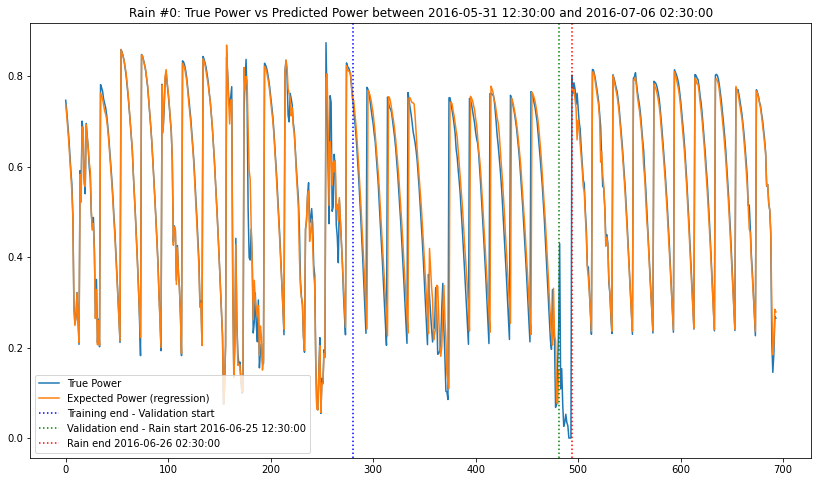

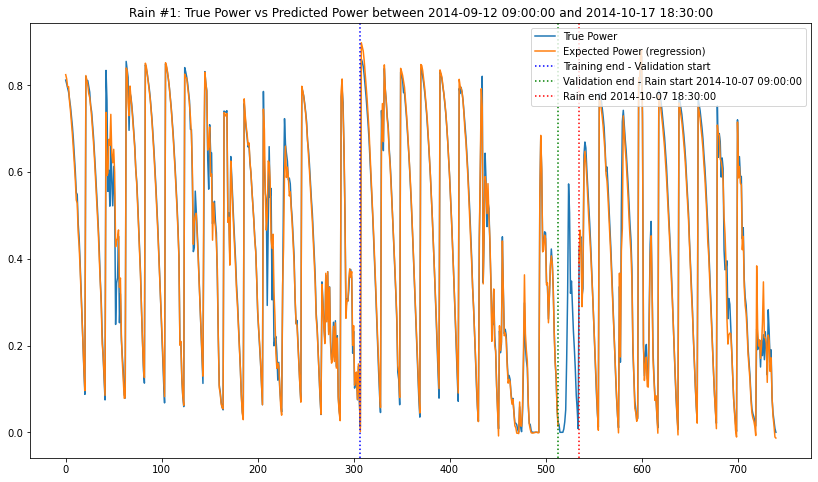

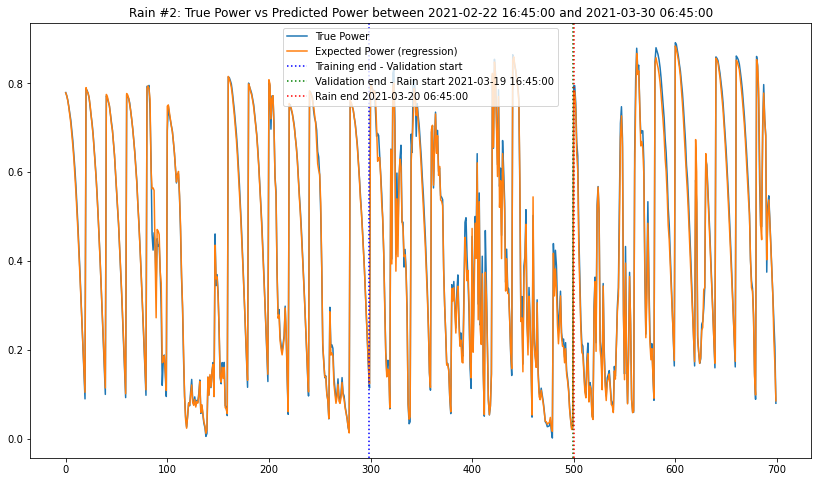

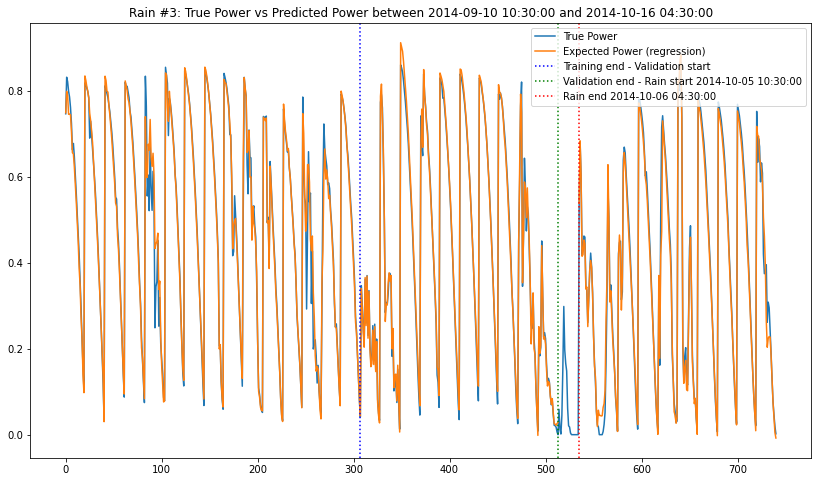

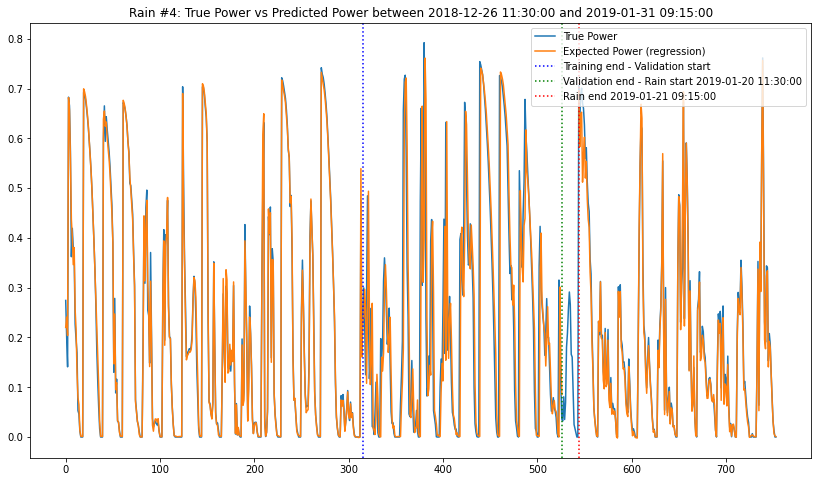

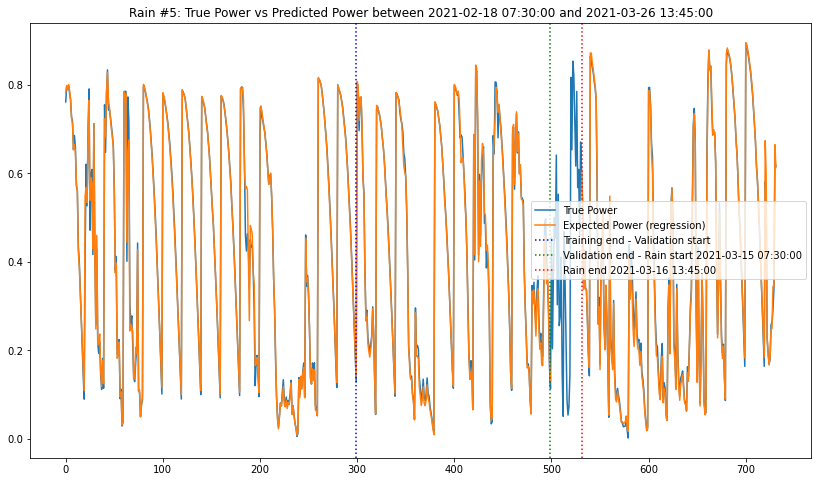

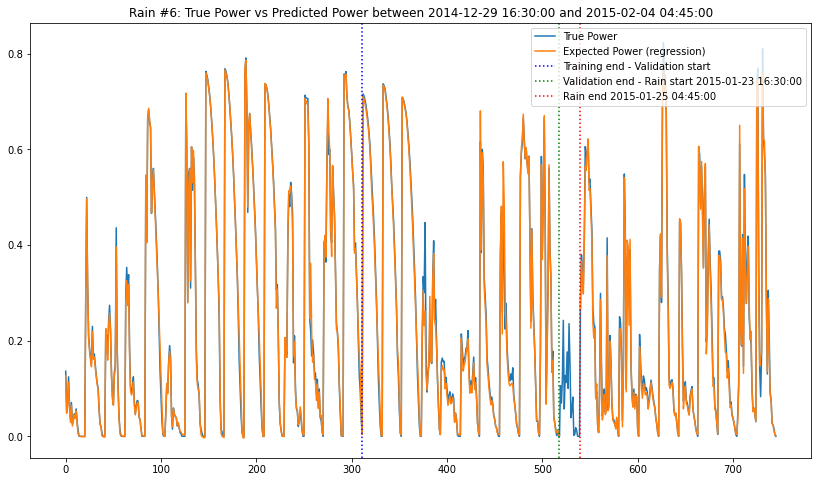

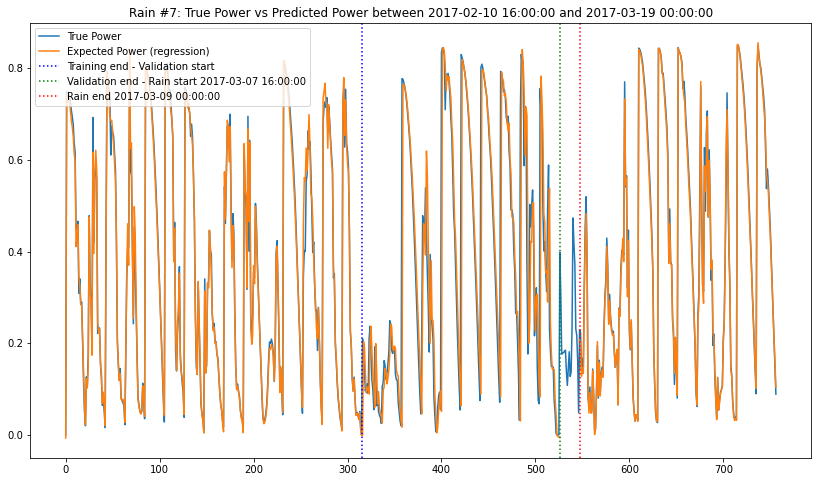

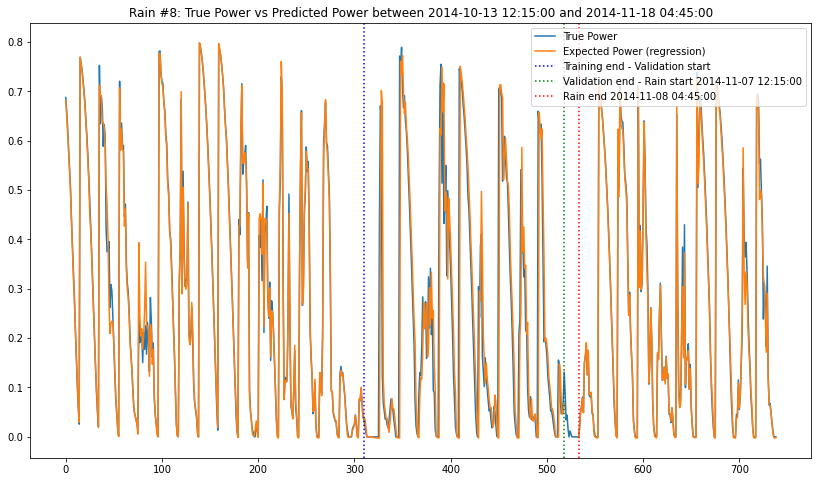

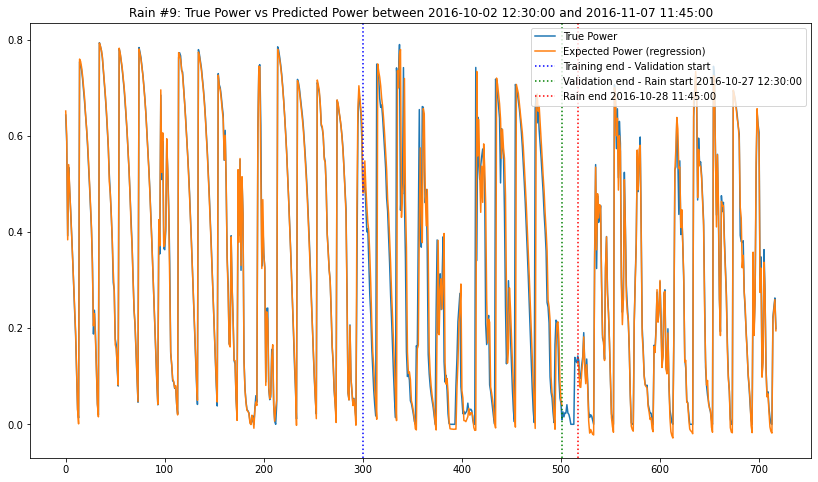

In [16]:
for n, i in enumerate(indices):
    d1 = dates_rain_start_filtered[i]
    d2 = dates_rain_stop_filtered[i]
    d0 = pd.to_datetime(d1) - pd.Timedelta(days=w1)-pd.Timedelta(days=w2)
    d3 = pd.to_datetime(d2) + pd.Timedelta(days=w3)
    
    plt.figure(figsize=(14,8))
    plt.title(f"Rain #{n}: True Power vs Predicted Power between {d0} and {d3}")
    plt.plot(df_one_array.loc[d0:d3].power.values, label="True Power")
    nobs = df_one_array.loc[d0:d3].shape[0]
    if (np.array(preds_train[i]).shape[0]) == 0:
        continue
    preds_empty = [np.nan] * (nobs - len(preds_train[i]) - len(preds_val[i])-len(preds_test[i])) 
    preds = np.hstack([preds_train[i], preds_val[i], preds_empty, preds_test[i]])
    plt.plot(preds, label="Expected Power (regression)")
    plt.axvline(x=preds_train[i].shape[0] - 1, color='b', linestyle=':', label=f'Training end - Validation start ')
    plt.axvline(x=preds_train[i].shape[0]+preds_val[i].shape[0] - 1, color='g', linestyle=':', label=f'Validation end - Rain start {d1}')
    plt.axvline(x=preds_train[i].shape[0]+preds_val[i].shape[0] + len(preds_empty), color='r', linestyle=':', label=f'Rain end {d2}')
    plt.legend()
    plt.show()